In [50]:
def convex_projection(u_grid, quantiles):
    # Convex projection in L2 using quadratic programming
    n = len(u_grid)
    Q = Variable(n) # Q as an optimization variable of length n

    #minimize the squared L2 distance between Q and the empirical quantile Q_emp
    objective = Minimize((1/n) * sum((Q[i] - quantiles[i])**2 for i in range(n)))  
    
    constraints = [Q[0] == 0]  # Q(0) = 0
    constraints += [Q[i] <= Q[i+1] for i in range(n - 1)]  # monotonicity
    constraints += [Q[i+2] - 2*Q[i+1] + Q[i] >= 0 for i in range(n - 2)]  # convexity, second difference > 0

    prob = Problem(objective, constraints)
    prob.solve()
    
    return Q.value

In [6]:
!pip install cvxpy



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.isotonic import IsotonicRegression
from cvxpy import Variable, Problem, Minimize
def empirical_quantile(data, grid_size=1000):
    data = np.sort(data) # increasing order
    n = len(data)     # number of data points
    u_grid = np.linspace(0, 1, grid_size) # Creates a grid of quantile levels u from 0 to 1
    # maps u -> Q(u)
    quantiles = np.interp(u_grid, np.linspace(0, 1, n, endpoint=False), data) # quantile levels i/n
    quantiles[0] = 0 
    return u_grid, quantiles

def convex_projection(u_grid, quantiles):
    # Convex projection in L2 using quadratic programming
    n = len(u_grid)
    Q = Variable(n) # Q as an optimization variable of length n
    #minimize the squared L2 distance between Q and the empirical quantile Q_emp
    objective = Minimize((1/n) * sum((Q[i] - quantiles[i])**2 for i in range(n)))  
    constraints = [Q[0] == 0] 
    constraints += [Q[i] <= Q[i+1] for i in range(n - 1)]  # monotonicity
    constraints += [Q[i+2] - 2*Q[i+1] + Q[i] >= 0 for i in range(n - 2)]  # convexity, second difference > 0

    prob = Problem(objective, constraints)
    prob.solve()
    return Q.value , prob.value

def estimate_density(u_grid, projected_quantiles):
    # inverting it
    cdf_inv = interp1d(projected_quantiles, u_grid, bounds_error=False, fill_value=(0,1)) # define a numerical inverse
    x_vals = np.linspace(projected_quantiles[1], projected_quantiles[-1], 500) #Generate 500 x values in the range of interest
    u_vals = cdf_inv(x_vals) # u = F(x)
    density_vals = np.gradient(u_vals, x_vals) # du/dx ≈ f(x)
    return x_vals, density_vals

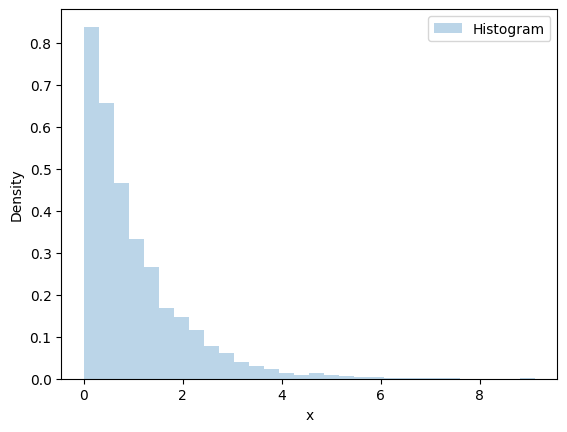

In [52]:
data = np.random.exponential(scale=1.0, size=5000) # 500 random samples from an Exponential(λ=1) distribution

u, Q_emp = empirical_quantile(data) #Computes the empirical quantile function
#Applies a Wasserstein-based convex projection to the empirical quantile function Q_emp, producing a monotone, convex-optimized quantile function
Q_proj = convex_projection(u, Q_emp)[0]
#estimates the probability density function corresponding to the smoothed quantile function Q_proj
x, f_hat = estimate_density(u, Q_proj)

# plt.plot(x, f_hat, label='Wasserstein density estimate')
plt.hist(data, bins=30, density=True, alpha=0.3, label='Histogram')
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000
525000
530000
535000
540000
545000
550000
555000
560000
565000
570000
575000
580000
585000
590000
595000
600000
605000
610000
615000
620000
625000
630000
635000
640000
645000
650000
655000
660000
665000
670000
675000
680000
685000
690000
695000
700000
705000
710000
715000
720000
725000
730000
735000
740000
745000
750000
755000
760000
765000
77

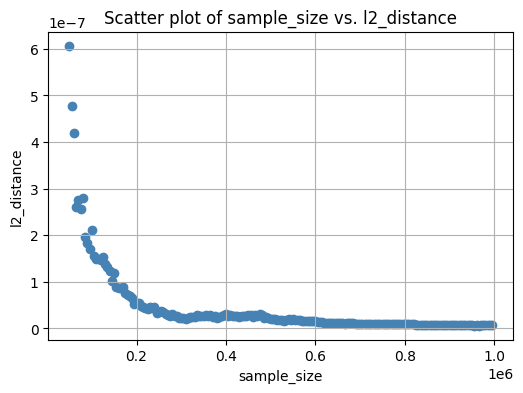

In [53]:


sample_size = []
l2_distance = []
data = np.random.exponential(scale=1.0, size=45000) 

n = 500
for n in range(50000,1000000,5000):
    print(n)
    try:
        other = np.random.exponential(scale=1.0, size=5000) 
        data = np.concatenate([data, other])
        u, Q_emp = empirical_quantile(data) 
        distance = convex_projection(u, Q_emp)[1]
        l2_distance.append(distance)
        sample_size.append(n)
    except Exception as e:
        # Any solver failure or feasibility issue → skip this n
        print(f"solver failed for n = {n}: {e}")
        continue

plt.figure(figsize=(6, 4))
plt.scatter(sample_size, l2_distance, color="steelblue", marker="o")
plt.xlabel("sample_size")
plt.ylabel("l2_distance")
plt.title("Scatter plot of sample_size vs. l2_distance")
plt.grid(True)
plt.show()



In [54]:
np.savetxt("data.csv", data.reshape(-1,1), delimiter=",")
np.savetxt("Wasserstein_distance.csv", l2_distance)


In [55]:
import pandas as pd
l2_distance_df = pd.read_csv("Wasserstein_distance.csv")
# sample_size_a = range(50000,1000000,5000)
sample_size_a = range(50000,1000000,5000)

sample_size = np.array(list(sample_size_a[:-1]))
l2_distance = l2_distance_df.iloc[:,0].tolist()
sqrt_l2_distance = np.sqrt(l2_distance)
ln_sqrt_l2_distance = np.log(sqrt_l2_distance)
ln_sample_size = np.log(sample_size)
# ln_sample_size, ln_sqrt_l2_distance

In [5]:
len(ln_sample_size)
# len(ln_sqrt_l2_distance)

189

In [49]:
len(sample_size_a)


190

In [41]:
grenander_distance_df = pd.read_csv("grenander_distance .csv")
sample_size_grenander = np.array(list(grenander_distance_df.x))
grenander_distance = np.array(list(grenander_distance_df.y))
ln_grenander_distance = np.log(grenander_distance)
ln_sample_size_grenander = np.log(sample_size_grenander)


len(ln_grenander_distance)

151

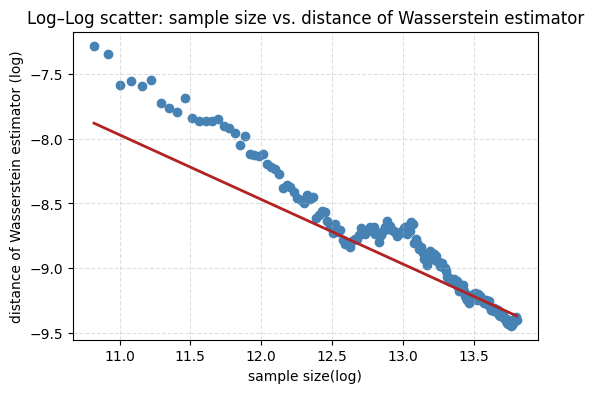

In [60]:





m = -0.5

b = ln_sqrt_l2_distance[0] - m * ln_sample_size[0] - 0.6



# build a reference x‐grid over the range of your log‐x data
x_ref = np.linspace(ln_sample_size.min(), ln_sample_size.max(), 200)
y_ref = m * x_ref + b


plt.figure(figsize=(6, 4))
plt.scatter(ln_sample_size, ln_sqrt_l2_distance, color="steelblue", marker="o")
# plt.scatter(ln_sample_size_grenander, ln_grenander_distance, color="red", marker="o")



plt.plot(x_ref, y_ref, color="firebrick", lw=2,
         label=r"reference slope $-0.5$")

plt.xlabel("sample size(log)")
plt.ylabel("distance of Wasserstein estimator (log)")
plt.title("Log–Log scatter: sample size vs. distance of Wasserstein estimator")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


In [36]:
print(len(ln_sample_size), len(ln_sqrt_l2_distance))




979 979


In [5]:
data.shape





(998999, 1)

SyntaxError: invalid syntax (2455667906.py, line 15)

In [ ]:

sample_size  = np.asarray(sample_size, dtype=float) 
x_inv = 1.0 / sample_size                   # 1/x

plt.figure(figsize=(6, 4))
plt.scatter(x_inv, l2_distance, color="steelblue")

plt.xlabel("1 / sample size")
plt.ylabel("L2 distance")
plt.title("Scatter plot: 1/n  vs  L2 distance")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume sample_size and l2_distance are Python lists already filled
sample_size  = np.asarray(sample_size, dtype=float)
l2_distance  = np.asarray(l2_distance, dtype=float)

x_inv = 1.0 / sample_size                  # 1/n   (or 1/np.sqrt(sample_size) if you like)

# ---------- 1. simple linear regression on the original scale ----------
slope, intercept = np.polyfit(x_inv, l2_distance, deg=1)   # y ≈ intercept + slope·x
y_hat = intercept + slope * x_inv

plt.figure(figsize=(6, 4))
plt.scatter(x_inv, l2_distance, color="steelblue", label="data")
plt.plot(x_inv, y_hat, color="firebrick", lw=2, label=f"OLS line  y={intercept:.2g}+{slope:.2g}x")

plt.xlabel("1 / sample size")
plt.ylabel("L2 distance")
plt.title("Scatter with OLS regression line")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()


In [ ]:

sample_size  = np.asarray(sample_size, dtype=float) 

x_inv_sqrt = 1.0 / np.sqrt(sample_size) 

plt.figure(figsize=(6, 4))
plt.scatter(x_inv, l2_distance, color="steelblue")

# plt.xscale("log")                           # optional: log scale for 1/x
# plt.yscale("log")                           # optional
plt.xlabel("1 / sample size")
plt.ylabel("L2 distance")
plt.title("Scatter plot: 1/sqrt(n)  vs  L2 distance")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter
from PIL import Image
import os

def grenander_data(data, start, step, end, l):
    # Activate numpy to R conversion
    with localconverter(ro.default_converter + numpy2ri.converter):
        ro.globalenv['data_r'] = ro.conversion.py2rpy(data)
        ro.globalenv['start'] = ro.conversion.py2rpy(start)
        ro.globalenv['step'] = ro.conversion.py2rpy(step)
        ro.globalenv['end'] = ro.conversion.py2rpy(end)
        ro.globalenv['lambda'] = ro.conversion.py2rpy(l)

    # R script to run
    ro.r('''
        library(ggplot2)
        library(fdrtool)
        library(patchwork)

        l2_distance_grenander_exp <- function(data, lambda) {
            F <- ecdf(data)
            g <- grenander(F)
            x_knots <- g$x.knots
            f_knots <- g$f.knots

            l2_sq_sum <- 0
            for (i in 1:(length(x_knots) - 1)) {
                a <- x_knots[i]
                b <- x_knots[i + 1]
                h <- f_knots[i]
                integrand <- function(x) (h - lambda * exp(-lambda * x))^2
                l2_sq_sum <- l2_sq_sum + integrate(integrand, lower = a, upper = b)$value
            }
            xmax = max(x_knots)
            tail_area <- (lambda/2)*exp(-2*lambda*xmax)
            return(sqrt(l2_sq_sum + tail_area))
        }

        convergence_gren <- function(data, start, end, step, lambda) {
            n <- start
            i <- 1
            num_steps <- floor((end - start) / step) + 1
            y_values <- numeric(num_steps)
            sample_sizes <- numeric(num_steps)

            while (n <= end) {
                x_values <- data[1:n]
                y_values[i] <- l2_distance_grenander_exp(x_values, lambda)
                sample_sizes[i] <- n
                n <- n + step
                i <- i + 1
            }

            threshold <- 1
            keep_indices <- which(y_values <= threshold)

            filtered_x <- sample_sizes[keep_indices]
            filtered_y <- y_values[keep_indices]

            df <- data.frame(x = filtered_x, y = filtered_y)
            filename <- paste0("grenander_data_lambda=", lambda, ".csv")
            write.csv(df, filename, row.names = FALSE)

            p <- ggplot(df, aes(x = x, y = y)) +
                geom_point(color = "blue") +
                geom_line(color = "blue") +
                labs(title = paste("L2 Distance between Grenander Estimator and Exp(", lambda, ")", sep = ""),
                     x = "Number of Samples",
                     y = "L2 Distance") +
                theme_minimal()

            model <- lm(log10(filtered_y) ~ log10(filtered_x))
            slope <- round(coef(model)[2], 3)

            df_log <- data.frame(x = log10(filtered_x), y = log10(filtered_y))
            plog <- ggplot(df_log, aes(x = x, y = y)) +
                geom_point(color = "blue") +
                geom_smooth(method = "lm", se = FALSE, color = "black") +
                annotate("text", x = min(df_log$x), y = max(df_log$y),
                         label = paste("Slope =", slope),
                         hjust = 0, vjust = 1, size = 5, fontface = "bold") +
                labs(title = paste("Log-Log Plot (Exp(", lambda, "))", sep = ""),
                     x = "log10(Number of Samples)",
                     y = "log10(L2 Distance)") +
                theme_minimal()

            return(p | plog)
        }

        convergence_gren(data_r, start, end, step, lambda)
    ''')

    # After R finishes, load the CSV file back into Python
    csv_filename = f"grenander_data_lambda={l}.csv"
    if os.path.exists(csv_filename):
        df = pd.read_csv(csv_filename)
    else:
        print(f"CSV file {csv_filename} not found.")
        df = None

    # Optionally display the plot if you saved it (not included in R code here)
    img_path = "grenander_plot.png"
    if os.path.exists(img_path):
        img = Image.open(img_path)
        img.show()
    else:
        print("Plot not found.")

    return df









       x         y
0  20000  0.030722
1  20500  0.030021
2  21000  0.030129
3  21500  0.029337
4  22000  0.029318


In [ ]:
# Example of usage:
np.random.seed(123)
data = np.random.exponential(scale=1.0, size=50000)
df_result = grenander_data(data, start=20000, step=500, end=50000, l=1)
print(df_result.head())

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Assume sample_size and l2_distance are Python lists already filled
sample_size  = np.asarray(sample_size, dtype=float)
l2_distance  = np.asarray(l2_distance, dtype=float)

x_inv_sqrt = 1.0 / np.sqrt(sample_size) 


# ---------- 1. simple linear regression on the original scale ----------
slope, intercept = np.polyfit(x_inv, l2_distance, deg=1)   # y ≈ intercept + slope·x
y_hat = intercept + slope * x_inv

plt.figure(figsize=(6, 4))
plt.scatter(x_inv, l2_distance, color="steelblue", label="data")
plt.plot(x_inv, y_hat, color="firebrick", lw=2, label=f"OLS line  y={intercept:.2g}+{slope:.2g}x")

plt.xlabel("1 / sample size")
plt.ylabel("L2 distance")
plt.title("Scatter with OLS regression line")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()


NameError: name 'sample_size' is not defined

In [ ]:
from scipy.stats import linregress

def linreg_report(x, y, name=""):
    res = linregress(x, y)
    print(f"[{name}]  slope = {res.slope:.4g},  intercept = {res.intercept:.4g}")
    print(f"          R^2  = {res.rvalue**2:.4f}")
    print(f"          p-value for slope ≠ 0  = {res.pvalue:.3g}")
    return res

# 1/n model
res1 = linreg_report(x_inv, l2_distance, name="1/n")

# 1/sqrt(n) model
res2 = linreg_report(x_inv_sqrt, l2_distance, name="1/sqrt(n)")


In [ ]:
def sample_power_law(p, size=1000):

    if p <= 1:
        raise ValueError("Power p must be greater than 1 for a valid distribution.")
    u = np.random.uniform(0, 1, size)
    x = (1 - u) ** (-1 / (p - 1)) - 1 
    return x

In [ ]:
data = sample_power_law(80, size=5000) # 500 random samples from an Exponential(λ=1) distribution

u, Q_emp = empirical_quantile(data) #Computes the empirical quantile function
#Applies a Wasserstein-based convex projection to the empirical quantile function Q_emp, producing a monotone, convex-optimized quantile function
Q_proj = convex_projection(u, Q_emp)[0] 
#estimates the probability density function corresponding to the smoothed quantile function Q_proj
x, f_hat = estimate_density(u, Q_proj)

# plt.plot(x, f_hat, label='Wasserstein density estimate')
plt.hist(data, bins=30, density=True, alpha=0.3, label='Histogram')
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.show()